In [16]:
import rasterio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt
import rioxarray as rxr
from shapely.geometry import box
import geopandas as gpd
from rasterio.mask import mask
from pyproj import Transformer
import json

# load tif file
raster = rasterio.open('/home/h99g576/anna-gphy484/anna-gphy484/files/PSScene/20230705_172241_41_2430/analytic_udm2/20230705_172241_41_2430_3B_AnalyticMS.tif')

# Normalize bands into 0.0 - 1.0 scale
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

## Clip data to CARC geography

In [13]:
# define lat/lon bounding box (CARC)
lat_min, lat_max = 47.0520, 47.0704
lon_min, lon_max = -109.946, -109.969

# set up transformer
transformer = Transformer.from_crs('EPSG:4326', raster.crs, always_xy=True)

# transform corners
xmin, ymin = transformer.transform(lon_min, lat_min)
xmax, ymax = transformer.transform(lon_max, lat_max)

# create polygon geometry and clip
bbox = box(xmin, ymin, xmax, ymax)

# convert to geoJSON format
geo = gpd.GeoSeries([bbox], crs=raster.crs)
geo_json = [json.loads(geo.to_json())['features'][0]['geometry']]

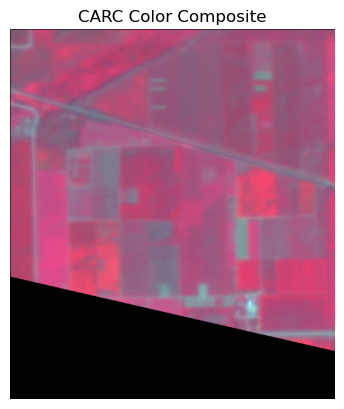

In [17]:
# mask (clip) image
# clip all bands
clipped, clipped_transform = mask(raster, geo_json, crop=True)

# extract inidividual bands from clipped data
nir = clipped[3]
red = clipped[2]
green = clipped[1]

# normalize clipped bands
nir_norm = normalize(nir)
red_norm = normalize(red)
green_norm = normalize(green)

# stack bands and plot
nrg = np.dstack((nir_norm, red_norm, green_norm))
plt.title('CARC Color Composite')
plt.axis('off')
plt.imshow(nrg)
plt.show()

## NDVI

In [18]:
# from https://developers.planet.com/docs/planetschool/calculate-an-ndvi-in-python/
# allow division by zero
np.seterr(divide='ignore', invalid='ignore')

# Calculate NDVI
ndvi = (nir_norm.astype(float) - red_norm.astype(float)) / (nir_norm + red_norm)

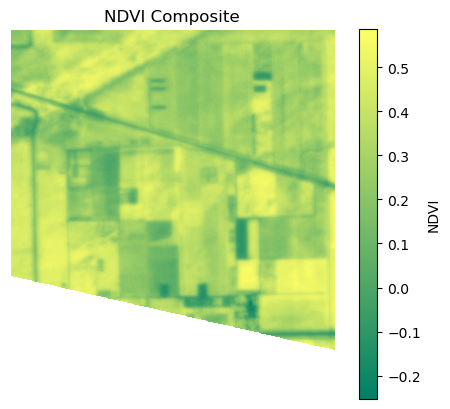

In [19]:
# Set spatial characteristics of the output object to mirror the input
kwargs = raster.meta
kwargs.update(
    dtype=rasterio.float32,
    count = 1)

# Create the file
with rasterio.open('ndvi.tif', 'w', **kwargs) as dst:
        dst.write(ndvi.astype(rasterio.float32), )

plt.imsave('ndvi_cmap.png', ndvi, cmap=plt.cm.summer)

plt.imshow(ndvi, cmap='summer')
plt.colorbar(label='NDVI')
plt.title('NDVI Composite')
plt.axis('off')  

plt.show()

## Code graveyard

In [ ]:
# Convert to numpy arrays
#nir = raster.read(4)
#red = raster.read(3)
#green = raster.read(2)

# Normalize band DN
#nir_norm = normalize(nir)
#red_norm = normalize(red)
#green_norm = normalize(green)

# Stack bands
#nrg = np.dstack((nir_norm, red_norm, green_norm))

# View the color composite
#plt.imshow(nrg)

#img.isel(band=0).plot()
#plt.show()

#red_band = red_band.squeeze()
#green_band = green_band.squeeze()
#blue_band = blue_band.squeeze()

# stack bands into 3D array
#rgb = np.stack((red_band, green_band, blue_band), axis = -1)

# normalize values to [0,1] range for display
#rgb = rgb.astype(np.float32)
#rgb /= 255

#if rgb.max() > 255:
    #rgb /= 65535
    
# plot

#img.plt()